In [59]:
### Copy from https://www.kaggle.com/kpacocha/top-5-titanic-machine-learning-from-disaster

In [60]:
import statsmodels
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import math 
import xgboost as xgb
np.random.seed(2019)
from scipy.stats import skew
from scipy import stats

import statsmodels
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns',100)

In [61]:
### import data 
def read_and_concat_dataset(training_path, test_path):
    train = pd.read_csv(training_path)
    train['train'] = 1
    test = pd.read_csv(test_path)
    test['train'] = 0
    data = train.append(test, ignore_index=True)
    return train, test, data

train, test, data = read_and_concat_dataset('train.csv', 'test.csv')
data = data.set_index('PassengerId')

In [62]:
data.head(2)

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,train
PassengerId,,,,,,,,,,,,
1,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171,1
2,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,PC 17599,1


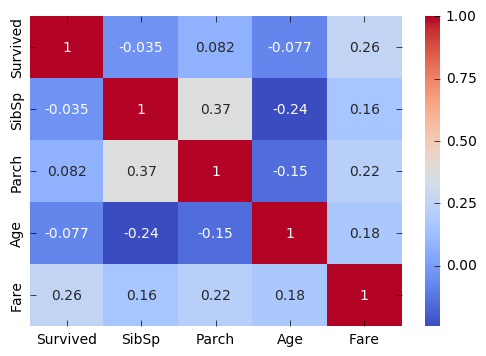

In [63]:
### data explore - correction from ## 相关值并不是很高，不高并不代表变量不重要
g = sns.heatmap(data[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, cmap = "coolwarm")

In [64]:
###两个重要的函数
###函数1
def comparing(data,v1, v2):  # sort_values(by=v2,ascending=False) -> 对v2的结果从大到小排列
    #print(data[[v1, v2]][data[v2].isnull()==False].groupby([v1],as_index=False).mean().sort_values(by=v2,ascending=False))
    g = sns.FacetGrid(data, col=v2,height =3).map(sns.distplot, v1)
    
def counting_values(data, v1, v2):  #这个结果已经在上面中用到了- 结果按照降序排列显示
    return data[[v1, v2]][data[v2].isnull()==False].groupby([v1], as_index=False).mean().sort_values(by=v2, ascending=False)

In [65]:
counting_values(data, 'Parch','Survived')

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


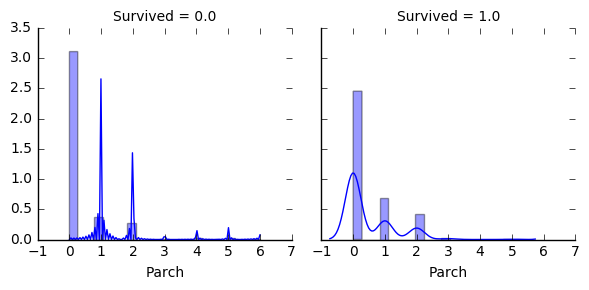

In [66]:
### Parch vs Survived 
comparing(data, 'Parch','Survived')

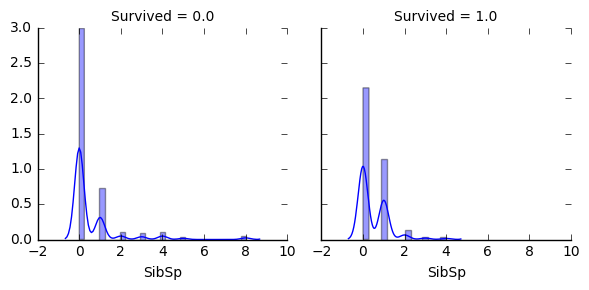

In [67]:
### SibSp vs Survived 
comparing(data, 'SibSp','Survived')

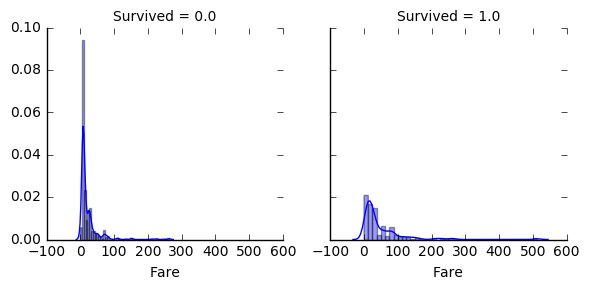

In [68]:
### Fare vs Survived 
comparing(data, 'Fare','Survived')

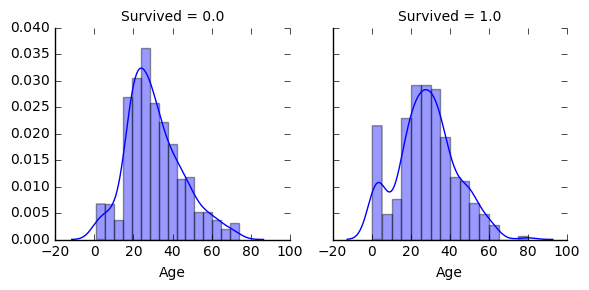

In [69]:
### Age vs Survived 
comparing(data, 'Age','Survived')

In [70]:
### Sex vs Survived 
counting_values(data, 'Sex','Survived')

,Sex,Survived
0,female,0.742038
1,male,0.188908


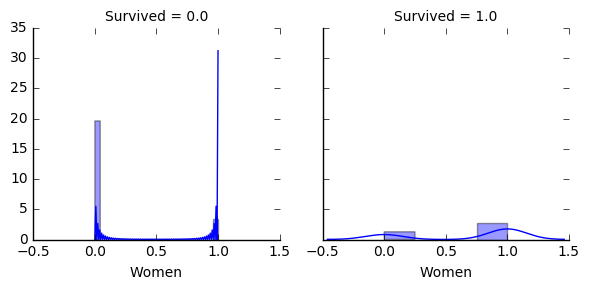

In [71]:
### np.where(condition,x,y) ## 将所有满足条件condition的元素都置为x,否则置为y
### women
data['Women'] = np.where(data['Sex'] == 'female',1,0)
comparing(data, 'Women','Survived')

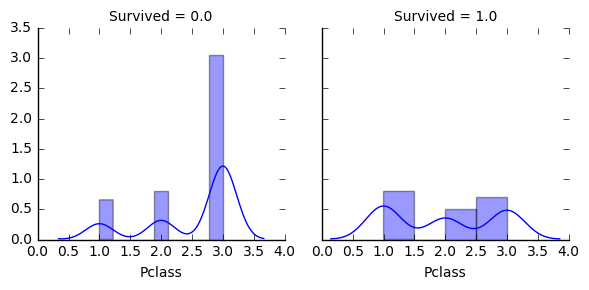

In [72]:
### Pclass vs Survived 
comparing(data, 'Pclass','Survived')

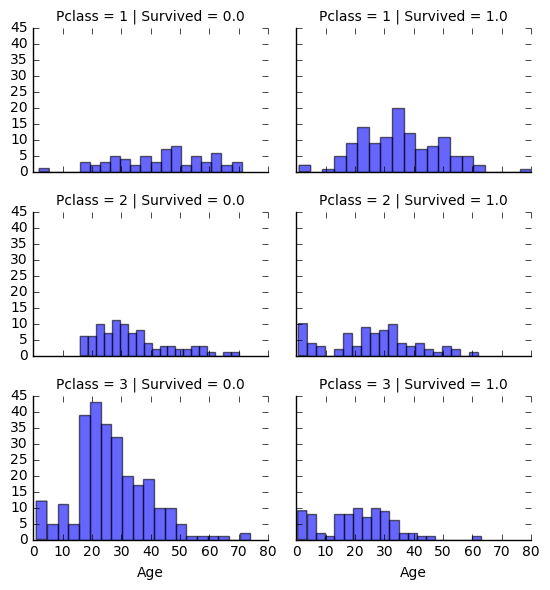

In [73]:
grid = sns.FacetGrid(data, col='Survived', row='Pclass', size=2, aspect=1.4)
grid.map(plt.hist, 'Age', alpha=0.6, bins=20)

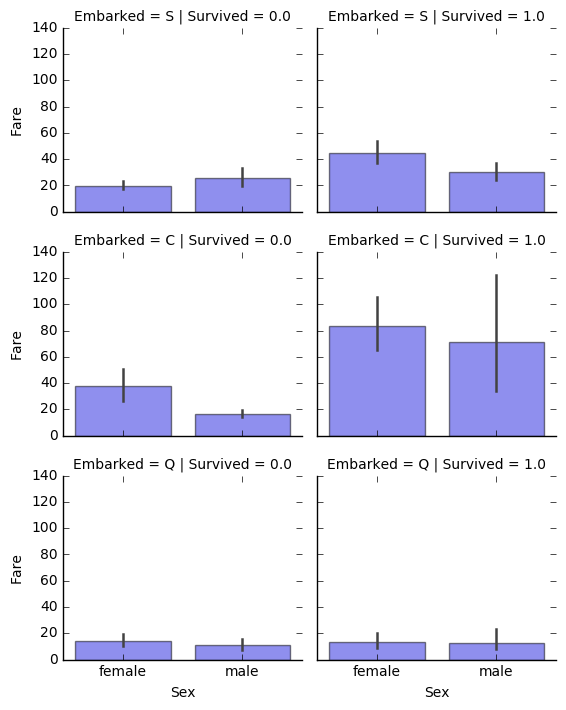

In [74]:
### Embarked vs Survived
grid = sns.FacetGrid(data,col = 'Survived',row = 'Embarked',height  = 2.4,aspect = 1.2)
grid.map(sns.barplot,'Sex','Fare',alpha=0.5)

In [75]:
### Missing Values
data.isnull().sum()

Age          263
Cabin       1014
Embarked       2
Fare           1
Name           0
Parch          0
Pclass         0
Sex            0
SibSp          0
Survived     418
Ticket         0
train          0
Women          0
dtype: int64

In [76]:
###  For Fare, fillin 0 for null data 
###  For Embarked, fill in 'S' for null data 
data.groupby('Pclass').Fare.mean()  # Pclass 三种座舱票价的均值

Pclass
1    87.508992
2    21.179196
3    13.302889
Name: Fare, dtype: float64

In [77]:
data.Fare = data.Fare.fillna(0)

In [78]:
data.Embarked = data.Embarked.fillna('S')

In [79]:
### For cabin as lose too much data ,use 'Unknown' for Canbin
data.Cabin = data.Cabin.fillna('Unknown')
data.Cabin = data.Cabin.str[0]

In [80]:
data.groupby("Pclass").Cabin.value_counts()

Pclass  Cabin
1       C         94
        U         67
        B         65
        D         40
        E         34
        A         22
        T          1
2       U        254
        F         13
        D          6
        E          4
3       U        693
        F          8
        G          5
        E          3
Name: Cabin, dtype: int64

In [81]:
### Pclass 1 中将 U替换成C; Pclass 2中将U 替换成D;Pclass 3中将U 替换成G
data['Cabin'] =  np.where(
            (data.Pclass == 1) & (data.Cabin =='U'),'C',
    np.where(
           (data.Pclass == 2) & (data.Cabin == 'U'),'D',
    np.where(
            (data.Pclass == 3) & (data.Cabin == 'U'),'G',
    np.where(
            data.Cabin == 'T','C',data.Cabin
            )
        )
    )
)

In [82]:
### Title 
data['Title'] = data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(data['Title'], data['Sex'])
data = data.drop('Name',axis=1)

In [83]:
data['Title'] = np.where(
    (data['Title'] == 'Don')|(data['Title'] == 'Rev')|(data['Title'] == 'Major')|(data['Title'] == 'Lady')|
    (data['Title'] == 'Sir')|(data['Title'] == 'Col')|(data['Title'] == 'Capt')|(data['Title'] == 'Countess')|
    (data['Title'] == 'Jonkheer')|(data['Title'] == 'Dona'),'Other',data.Title
)
data['Title'] = data['Title'].replace('Ms','Miss')
data['Title'] = data['Title'].replace('Mlle','Miss')
data['Title'] = data['Title'].replace('Mme','Mrs')

In [84]:
### 按照title的幸存率
data[['Title','Survived']].groupby('Title',as_index = False).mean().sort_values(by = 'Survived',ascending = True)

,Title,Survived
3,Mr,0.156673
5,Other,0.312500
0,Dr,0.428571
1,Master,0.575000
2,Miss,0.702703
4,Mrs,0.793651


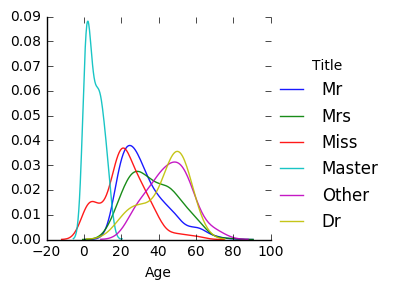

In [85]:
### Master title的幸存率比较高，主要是这部分人年龄偏小，可能都是小孩
grid  = sns.FacetGrid(data,height  = 3,hue = "Title").map(sns.kdeplot,'Age',alpha = 1.9).add_legend()

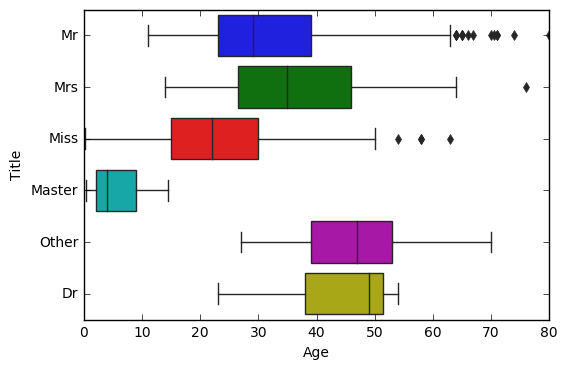

In [86]:
### 在看看title跟 Age的关联
sns.boxplot(data=data,x="Age",y = "Title")  #Master年龄都在小年纪的部分

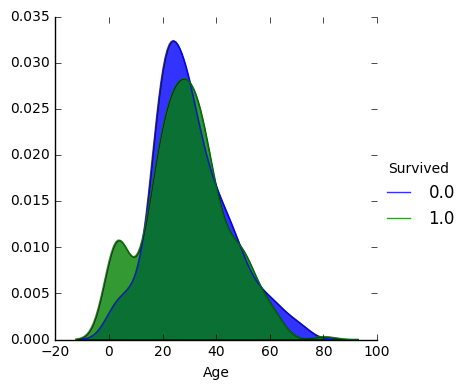

In [87]:
### Age更幸存率的影响
grid = sns.FacetGrid(data,hue = "Survived",size = 4).map(sns.kdeplot,'Age',shade =True,alpha=0.8).add_legend()

In [88]:
### Age 分布的区域较广；对于缺失的Age要更具Tiltle的特定范围来填充
### 先看看每个title的Age均值，在对应填充
data.groupby('Title').Age.mean()

Title
Dr        43.571429
Master     5.482642
Miss      21.824366
Mr        32.252151
Mrs       36.918129
Other     45.714286
Name: Age, dtype: float64

In [89]:
###　对Age分段填充
data['Age'] = np.where(
            (data['Title'] == 'Dr')&(data.Age.isnull()),44,
    np.where( 
            (data['Title'] == 'Master')&(data.Age.isnull()),6,
    np.where( 
            (data['Title'] == 'Miss')&(data.Age.isnull()),22,
    np.where( 
                (data['Title'] == 'Mr')&(data.Age.isnull()),32,
    np.where( 
                    (data['Title'] == 'Mrs')&(data.Age.isnull()),37,
    np.where( 
                        (data['Title'] == 'other')&(data.Age.isnull()),46,data.Age
        )
      )
    ) 
  )
)
)

In [90]:
## feature enginnering - 新增加的特征
data['Mother'] = np.where(
    (data.Parch>1)&(data.Title == 'Mrs'),1,0)
data['Family_size'] = data['Parch'] + data['SibSp']  + 1
data['Ticket_Free'] = np.where((data['Fare'] == 0),1,0)
#data.drop(['Parch','SibSp','Sex'],axis=1)

In [91]:
import string
TypeOfTicket = []
for i in range(len(data.Ticket)):
    ticket = data.Ticket.iloc[i]
    for c in string.punctuation:
                ticket = ticket.replace(c,"")
                splited_ticket = ticket.split(" ")   
    if len(splited_ticket) == 1:
                TypeOfTicket.append('NO')
    else: 
                TypeOfTicket.append(splited_ticket[0])
            
data['TypeOfTicket'] = TypeOfTicket

data.TypeOfTicket.value_counts()
data['TypeOfTicket'] = np.where((data.TypeOfTicket!='NO') & (data.TypeOfTicket!='PC') & (data.TypeOfTicket!='CA') & 
                                (data.TypeOfTicket!='A5') & (data.TypeOfTicket!='SOTONOQ'),'OTHER',data.TypeOfTicket)
data = data.drop('Ticket',axis=1)

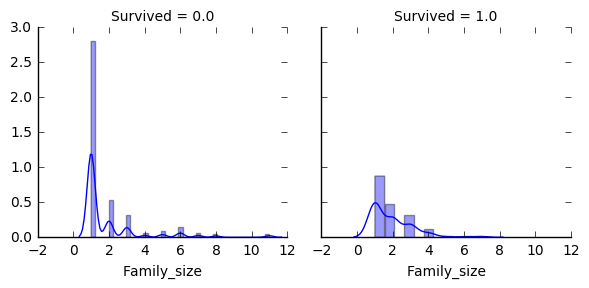

In [92]:
### Family_size vs Survived 
comparing(data,'Family_size','Survived')

In [93]:
### Title vs Survived
counting_values(data,'Title','Survived')  # female and baby get more optinuties to survived than man

,Title,Survived
4,Mrs,0.793651
2,Miss,0.702703
1,Master,0.575000
0,Dr,0.428571
5,Other,0.312500
3,Mr,0.156673


In [94]:
## TypeOfTicket vs Survived 
counting_values(data,'TypeOfTicket','Survived')

,TypeOfTicket,Survived
4,PC,0.650000
2,NO,0.383459
1,CA,0.341463
3,OTHER,0.337079
5,SOTONOQ,0.133333
0,A5,0.095238


In [95]:
### Cabin vs Survived 
counting_values(data,'Cabin','Survived')

,Cabin,Survived
4,E,0.750000
1,B,0.744681
5,F,0.615385
2,C,0.540000
3,D,0.492537
0,A,0.466667
6,G,0.238095


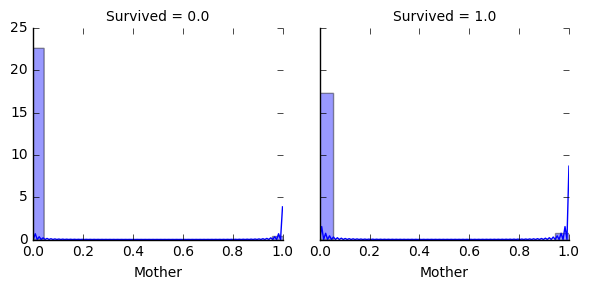

In [96]:
### Mother vs Survived 
comparing(data,'Mother','Survived')

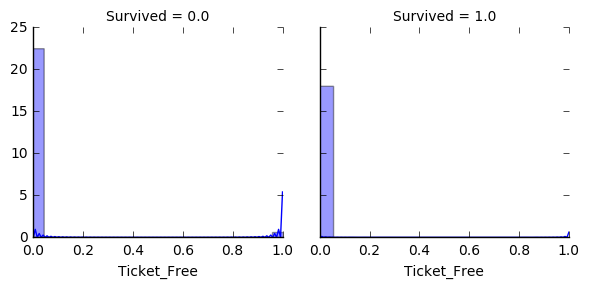

In [97]:
### Ticket_Free vs 
comparing(data,'Ticket_Free','Survived')

In [98]:
counting_values(data,'Ticket_Free','Survived')

,Ticket_Free,Survived
0,0,0.389269
1,1,0.066667


In [99]:
bins   = [0,12,24,45,60,data.Age.max()]
labels = ['Child', 'Young Adult', 'Adult','Older Adult','Senior']
data["Age"] = pd.cut(data["Age"], bins, labels = labels)

In [100]:
### 最终获得的样本如下
## features = {Age,Cabin,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Train,Women,
##             Title,Mother,Family_Size,Ticket_Free,TypeOfTicker}
data.head(3)

,Age,Cabin,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,train,Women,Title,Mother,Family_size,Ticket_Free,TypeOfTicket
PassengerId,,,,,,,,,,,,,,,,
1,Young Adult,G,S,7.2500,0,3,male,1,0.0,1,0,Mr,0,2,0,A5
2,Adult,C,C,71.2833,0,1,female,1,1.0,1,1,Mrs,0,2,0,PC
3,Adult,G,S,7.9250,0,3,female,0,1.0,1,1,Miss,0,1,0,OTHER


In [122]:
data_backup = data.copy()

In [124]:
### data to one-hot encoding
data  = pd.get_dummies(data)

In [125]:
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(data[data.Survived.isnull()==False].drop('Survived',axis=1),data.Survived[data.Survived.isnull()==False],test_size=0.30, random_state=2019)

In [126]:
Results = pd.DataFrame({'Model': [],'Accuracy Score': [], 'Recall':[], 'F1score':[]})

In [127]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

In [128]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=4)
model.fit(trainX, trainY)
y_pred = model.predict(testX)
res = pd.DataFrame({"Model":['DecisionTreeClassifier'],
                    "Accuracy Score": [accuracy_score(y_pred,testY)],
                   "Recall": [recall_score(testY, y_pred)],
                   "F1score": [f1_score(testY, y_pred)]})
Results = Results.append(res)
pd.crosstab(testY, y_pred, rownames=['Real data'], colnames=['Predicted'])

Predicted,0.0,1.0
Real data,,
0.0,163,13
1.0,32,60


In [129]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=2500, max_depth=4)
model.fit(trainX, trainY)
y_pred = model.predict(testX)
from sklearn.metrics import accuracy_score
res = pd.DataFrame({"Model":['RandomForestClassifier'],
                    "Accuracy Score": [accuracy_score(y_pred,testY)],
                   "Recall": [recall_score(testY, y_pred)],
                   "F1score": [f1_score(testY, y_pred)]})
Results = Results.append(res)
pd.crosstab(testY, y_pred, rownames=['Real data'], colnames=['Predicted'])

Predicted,0.0,1.0
Real data,,
0.0,159,17
1.0,26,66


In [130]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(trainX, trainY)
y_pred = model.predict(testX)
from sklearn.metrics import accuracy_score
res = pd.DataFrame({"Model":['KNeighborsClassifier'],
                    "Accuracy Score": [accuracy_score(y_pred,testY)],
                   "Recall": [recall_score(testY, y_pred)],
                   "F1score": [f1_score(testY, y_pred)]})
Results = Results.append(res)
pd.crosstab(testY, y_pred, rownames=['Real data'], colnames=['Predicted'])

Predicted,0.0,1.0
Real data,,
0.0,141,35
1.0,29,63


In [131]:
from sklearn.svm import SVC
model = SVC()
model.fit(trainX, trainY)
y_pred = model.predict(testX)
from sklearn.metrics import accuracy_score
res = pd.DataFrame({"Model":['SVC'],
                    "Accuracy Score": [accuracy_score(y_pred,testY)],
                   "Recall": [recall_score(testY, y_pred)],
                   "F1score": [f1_score(testY, y_pred)]})
Results = Results.append(res)
pd.crosstab(testY, y_pred, rownames=['Real data'], colnames=['Predicted'])

Predicted,0.0,1.0
Real data,,
0.0,135,41
1.0,18,74


In [132]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(trainX, trainY)
y_pred = model.predict(testX)
from sklearn.metrics import accuracy_score
res = pd.DataFrame({"Model":['LogisticRegression'],
                    "Accuracy Score": [accuracy_score(y_pred,testY)],
                   "Recall": [recall_score(testY, y_pred)],
                   "F1score": [f1_score(testY, y_pred)]})
Results = Results.append(res)
pd.crosstab(testY, y_pred, rownames=['Real data'], colnames=['Predicted'])

Predicted,0.0,1.0
Real data,,
0.0,151,25
1.0,22,70


In [133]:
from xgboost.sklearn import XGBClassifier
model = XGBClassifier(learning_rate=0.001,n_estimators=1500,
                                max_depth=4, min_child_weight=0,
                                gamma=0, subsample=0.7,
                                colsample_bytree=0.7,
                                scale_pos_weight=1, seed=27,
                                reg_alpha=0.00006)
model.fit(trainX, trainY)
y_pred = model.predict(testX)
from sklearn.metrics import accuracy_score
res = pd.DataFrame({"Model":['XGBClassifier'],
                    "Accuracy Score": [accuracy_score(y_pred,testY)],
                   "Recall": [recall_score(testY, y_pred)],
                   "F1score": [f1_score(testY, y_pred)]})
Results = Results.append(res)
pd.crosstab(testY, y_pred, rownames=['Real data'], colnames=['Predicted'])

Predicted,0.0,1.0
Real data,,
0.0,159,17
1.0,21,71


In [134]:
## Results
Results

,Accuracy Score,F1score,Model,Recall
0,0.832090,0.727273,DecisionTreeClassifier,0.652174
0,0.839552,0.754286,RandomForestClassifier,0.717391
0,0.761194,0.663158,KNeighborsClassifier,0.684783
0,0.779851,0.714976,SVC,0.804348
0,0.824627,0.748663,LogisticRegression,0.760870
0,0.858209,0.788889,XGBClassifier,0.771739


In [135]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
trainX = data[data.Survived.isnull()==False].drop(['Survived','train'],axis=1)
trainX = data[data.Survived.isnull()==False].drop(['Survived'],axis=1)
trainY = data.Survived[data.Survived.isnull()==False]
testX = data[data.Survived.isnull()==True].drop(['Survived','train'],axis=1)
testX = data[data.Survived.isnull()==True].drop(['Survived'],axis=1)
model = XGBClassifier(learning_rate=0.001,n_estimators=2500,
                                max_depth=4, min_child_weight=0,
                                gamma=0, subsample=0.7,
                                colsample_bytree=0.7,
                                scale_pos_weight=1, seed=27,
                                reg_alpha=0.00006)
model.fit(trainX, trainY)
test = data[data.train==0]
test['Survived'] = model.predict(testX).astype(int)
test = test.reset_index()
test[['PassengerId','Survived']].to_csv("submissionXGB.csv",index=False)
print("Done")

Done


In [136]:
submission_cheating = pd.read_csv('submission_cheating.csv')
np.sum(test['Survived'] == submission_cheating['Survived'])/len(submission_cheating['Survived'])

0.7918660287081339

In [58]:
print("%0.2f"%(100*727/16502),"%")

4.41 %
